
# Optode EDA & 3D Visualization

This notebook reproduces the 1" time-series plot and the 3D time–depth scatter plot we created.
- Update `BASE_ZIP_PATH` or `BASE_DIR` to point to your data.
- The code expects file names like `SMORES optode_6 3 inch.csv` and columns including `Epoch`, `DO`, `T`.


In [14]:

import os, re, math, zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['axes.grid'] = True


In [23]:

# === Configure data location ===
# If your files are in a zip, set BASE_ZIP_PATH and run the extraction cell.
BASE_ZIP_PATH = 'CSVperOptode_2.zip'   # change if needed
EXTRACT_DIR = '/home/raman-pc/smores_proj/CSVperOptode/'          # change if needed

# If you already have a folder with CSVs, set BASE_DIR and skip extraction.
BASE_DIR = EXTRACT_DIR


In [24]:

# Optional: extract from zip if the folder doesn't already exist
# import os
# if BASE_ZIP_PATH and not os.path.exists(EXTRACT_DIR):
    # with zipfile.ZipFile(BASE_ZIP_PATH, 'r') as zf:
        # zf.extractall(EXTRACT_DIR)
print('Data directory:', BASE_DIR)
for root, _, files in os.walk(BASE_DIR):
    print(f'  {len(files)} files in {root}')

Data directory: /home/raman-pc/smores_proj/CSVperOptode/
  52 files in /home/raman-pc/smores_proj/CSVperOptode/


In [25]:

def parse_info(fname):
    """Return (optode_id, depth_inch) from filename like 'SMORES optode_6 3 inch.csv'"""
    m = re.search(r'optode_(\d+)\s+(\d+)\s+inch', os.path.basename(fname))
    if not m:
        return None, None
    return int(m.group(1)), int(m.group(2))

# Collect csv files
csv_files = []
for root, _, files in os.walk(BASE_DIR):
    for f in files:
        if f.endswith('.csv') and 'optode_' in f:
            csv_files.append(os.path.join(root, f))

len(csv_files), csv_files[:5]


(26,
 ['/home/raman-pc/smores_proj/CSVperOptode/SMORES optode_14 1 inch.csv',
  '/home/raman-pc/smores_proj/CSVperOptode/SMORES optode_13 6 inch.csv',
  '/home/raman-pc/smores_proj/CSVperOptode/SMORES optode_3 3 inch.csv',
  '/home/raman-pc/smores_proj/CSVperOptode/SMORES optode_2 1 inch.csv',
  '/home/raman-pc/smores_proj/CSVperOptode/SMORES optode_27 3 inch.csv'])

In [26]:

# Read all CSVs robustly and standardize columns
records = []
for path in csv_files:
    oid, depth = parse_info(path)
    if oid is None:
        continue
    try:
        df = pd.read_csv(path)
    except UnicodeDecodeError:
        df = pd.read_csv(path, encoding='latin1')
    # Ensure required columns exist
    colmap = {c.strip(): c for c in df.columns}
    if 'Epoch' not in colmap or 'DO' not in colmap:
        continue
    df = df[[colmap['Epoch'], colmap['DO']]].rename(columns={colmap['Epoch']: 'Epoch', colmap['DO']: 'DO'})
    df['file'] = os.path.basename(path)
    df['optode_id'] = oid
    df['depth_inch'] = depth
    records.append(df)

all_df = pd.concat(records, ignore_index=True)
all_df['datetime'] = pd.to_datetime(all_df['Epoch'], unit='s', utc=True)
all_df['datetime'] = all_df['datetime'].dt.tz_convert('US/Eastern')
print('Rows:', len(all_df), ' | Optodes:', all_df.optode_id.nunique(), ' | Depths:', sorted(all_df.depth_inch.unique()))
all_df.head()


Rows: 17187  | Optodes: 26  | Depths: [np.int64(1), np.int64(3), np.int64(6)]


,Epoch,DO,file,optode_id,depth_inch,datetime
0,1.744035e+09,8.344990,SMORES optode_14 1 inch.csv,14,1,2025-04-07 10:13:20.283986568-04:00
1,1.744035e+09,8.344559,SMORES optode_14 1 inch.csv,14,1,2025-04-07 10:14:14.122994900-04:00
2,1.744035e+09,8.324755,SMORES optode_14 1 inch.csv,14,1,2025-04-07 10:15:06.377996206-04:00
3,1.744035e+09,8.318866,SMORES optode_14 1 inch.csv,14,1,2025-04-07 10:15:58.537986517-04:00
4,1.744035e+09,8.308474,SMORES optode_14 1 inch.csv,14,1,2025-04-07 10:16:50.894986629-04:00


## 1-inch Depth — DO Time Series

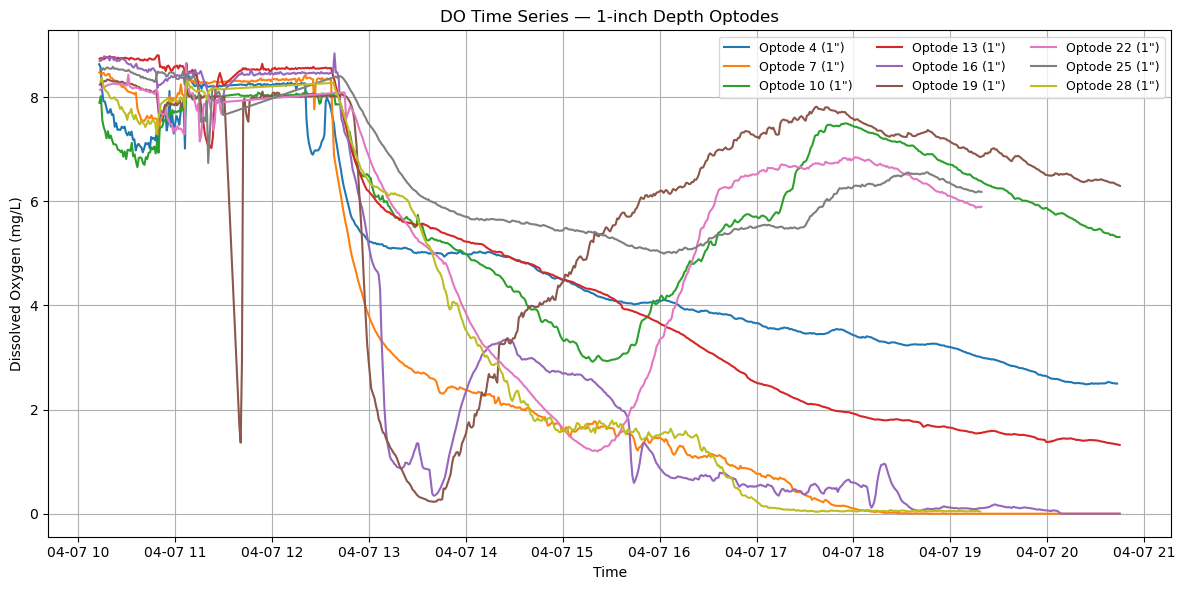

In [27]:

one_inch = all_df[all_df['depth_inch'] == 6].copy().sort_values(['optode_id','datetime'])

plt.figure(figsize=(12,6))
for oid, sub in one_inch.groupby('optode_id'):
    plt.plot(sub['datetime'], sub['DO'], label=f'Optode {oid} (1\")')
plt.xlabel('Time')
plt.ylabel('Dissolved Oxygen (mg/L)')
plt.title('DO Time Series — 1-inch Depth Optodes')
plt.legend(ncol=3, fontsize=9)
plt.tight_layout()
plt.show()


## 3D DO Time–Depth Plot (All Layers)

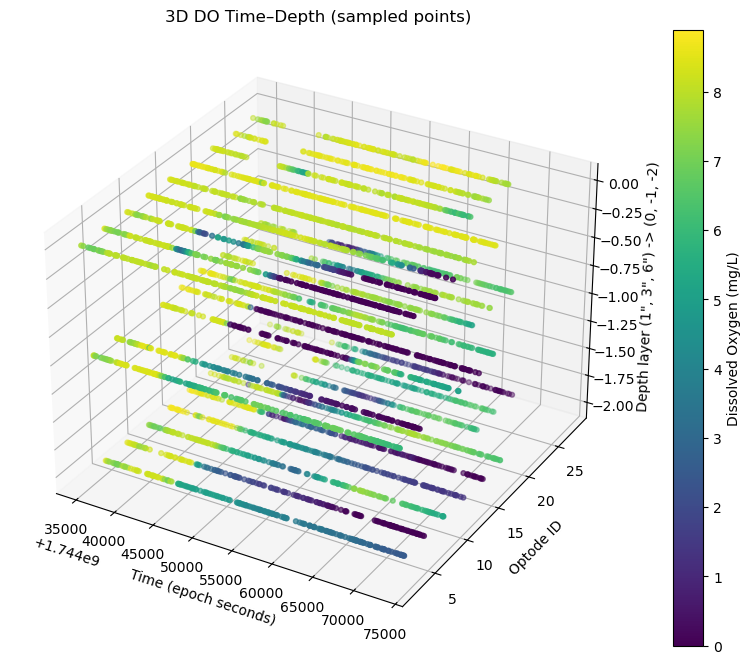

In [28]:

# Map depth to a simple z layer (higher = shallower)
depth_to_z = {1: 0, 3: -1, 6: -2}
plot_df = all_df.copy()
plot_df['z'] = plot_df['depth_inch'].map(depth_to_z)

# To keep rendering light, sample a subset; set to None for full plot
SAMPLE_N = 4000
if SAMPLE_N is not None and len(plot_df) > SAMPLE_N:
    plot_df = plot_df.sample(SAMPLE_N, random_state=42)

# Convert datetime to a numeric axis: epoch seconds
x_time = (plot_df['datetime'].astype('int64') // 10**9)

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(x_time, plot_df['optode_id'], plot_df['z'], c=plot_df['DO'], s=12)

ax.set_xlabel('Time (epoch seconds)')
ax.set_ylabel('Optode ID')
ax.set_zlabel('Depth layer (1", 3", 6") -> (0, -1, -2)')
ax.set_title('3D DO Time–Depth (sampled points)')
cb = plt.colorbar(sc, ax=ax)
cb.set_label('Dissolved Oxygen (mg/L)')
plt.show()


## Optional: Simplified 3D Arms Snapshot

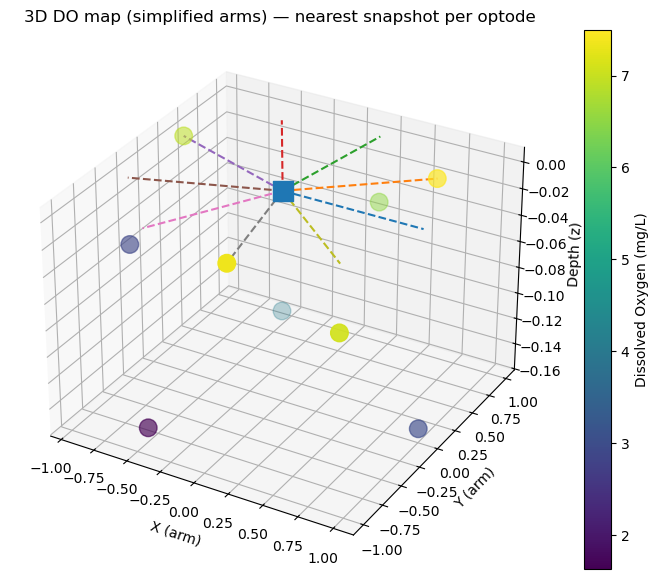

In [29]:

# Build a single-time snapshot by taking the row closest to the median time for each (optode, depth)
ref_epoch = all_df['Epoch'].median()
nearest = (all_df.assign(dist=(all_df['Epoch']-ref_epoch).abs())
           .sort_values(['optode_id','depth_inch','dist'])
           .groupby(['optode_id','depth_inch'], as_index=False)
           .first()[['optode_id','depth_inch','DO','Epoch']])

# Simplified radial arm layout (9 arms around a circle)
def arm_xy(arm_idx, R=1.0):
    theta = 2 * math.pi * (arm_idx % 9) / 9.0
    return R*math.cos(theta), R*math.sin(theta)

depth_to_z_snap = {1: 0.0, 3: -0.05, 6: -0.15}

coords = []
for _, r in nearest.iterrows():
    oid = int(r['optode_id'])
    arm = (oid - 1) % 9
    x, y = arm_xy(arm)
    z = depth_to_z_snap.get(int(r['depth_inch']), np.nan)
    if not np.isnan(z):
        coords.append((x,y,z,r['DO'],oid,int(r['depth_inch']),arm))

coords_df = pd.DataFrame(coords, columns=['x','y','z','DO','optode_id','depth_inch','arm'])
coords_df = coords_df.sort_values(['arm','depth_inch','optode_id']).drop_duplicates(['arm','depth_inch']).head(27)

fig = plt.figure(figsize=(9,7))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(coords_df['x'], coords_df['y'], coords_df['z'], c=coords_df['DO'], s=160)
ax.scatter([0],[0],[0], s=200, marker='s')  # lander
for arm in sorted(coords_df['arm'].unique()):
    x,y = arm_xy(int(arm))
    ax.plot([0,x],[0,y],[0,0], linestyle='--')

ax.set_xlabel('X (arm)'); ax.set_ylabel('Y (arm)'); ax.set_zlabel('Depth (z)')
ax.set_title('3D DO map (simplified arms) — nearest snapshot per optode')
cb = plt.colorbar(sc, ax=ax); cb.set_label('Dissolved Oxygen (mg/L)')
plt.show()
